# Fault Algebras

The main question being asked is, how to combine and negate fault patterns.

In [1]:
from enum import Enum
import copy

The faults can from several different inputs. The idea is that the characterizing node, and abstraction removes the influences of the specific parse tree.

## Fault Patterns

### Predicate

First, we define a way to capture the status of an input. There can be four outcomes when an input is executed:

* Success (failure condition reproduced)
* Failed (failure condition not reproduced)
* Invalid (Did not reach failure condition -- possibly semantically invalid)
* Timeout (equivalant to Failed)

In [2]:
class PRes(str, Enum):
    success = 'SUCCESS'
    failed = 'FAILED'
    invalid = 'INVALID'
    timeout = 'TIMEOUT'

Next, we define our predicate. It is a simple test for doubled parenthesis such as `((..))` or an expression `0 / 0`

In [3]:
import re

In [4]:
def expr_double_paren(inp):
    if re.match(r'.*[(][(].*[)][)].*', inp):
        return PRes.success
    #if re.match(r'.*0 / 0.*', inp):
    #    return PRes.success
    return PRes.failed

In [5]:
my_predicate = expr_double_paren

We also define an input.

In [6]:
expr_input =  '1 + ((2 * 3 / 4))'

In [7]:
my_input = expr_input

We verify that we can reproduce the failing condition correctly.

In [8]:
assert my_predicate(my_input) == PRes.success

In [9]:
assert my_predicate('(1 + 2)') == PRes.failed

In [10]:
assert my_predicate('0 / 0') == PRes.failed

### Grammar

A context-free grammar is represented as a Python dict, with each nonterminal symbol forming a key, and each nonterminal _defined_ by a list of expansion rules. For example, the expression grammar for parsing arithmetic expressions is given below.

In [11]:
EXPR_GRAMMAR = {'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

In [12]:
EXPR_G = {'[start]': '<start>', '[grammar]': EXPR_GRAMMAR}

Note the convetion we used: Each nonterminal is enclosed in angle brackets. E.g. `<expr>`. We now define a function that can distinguish terminal symbols from nonterminals.

The `is_nt()` function checks if the given node is a terminal or not.

In [13]:
def is_nt(symbol):
     return symbol and (symbol[0], symbol[-1]) == ('<', '>')

#### The parser

Given the grammar, and an input, we can parse it into a derivation tree.
The `Parser` below is from [fuzzingbook.org](https://www.fuzzingbook.org/html/Parser.html), and provides a generic context-free parser. This is present in the `src` directory.

In [14]:
from Parser import EarleyParser as Parser

How do we check that our parse succeeded? We can convert the derivation tree back to the original string and check for equality.

The `tree_to_str()` function converts a derivation tree to its original string.

In [15]:
def tree_to_str(node):
    name, children, *rest = node
    if not children:
        return name
    return ''.join([tree_to_str(c) for c in children])

In [16]:
Ts = tree_to_str

In [17]:
expr_parser = Parser(EXPR_GRAMMAR, start_symbol='<start>', canonical=True)
parsed_expr = list(expr_parser.parse(my_input))[0]
tree_to_str(parsed_expr)

'1 + ((2 * 3 / 4))'

#### Display

While converting to strings are easy, it is unsatisfying. We want to make our output look pretty, and inspect the tree structure of the parsed tree. So we define graphical tree display (code from fuzzingbook)

In [18]:
from graphviz import Digraph

In [19]:
from IPython.display import display, Image

In [20]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

In [21]:
class DisplayTree():
    def __init__(self):
        pass

    def extract_node(self, node, id):
        symbol, children, *annotation = node
        return symbol, children, ''.join(str(a) for a in annotation)
    
    def node_attr(self, dot, nid, symbol, ann):
        dot.node(repr(nid), symbol + ' ')
        
    def edge_attr(self, dot, start_node, stop_node):
        dot.edge(repr(start_node), repr(stop_node))
        
    def graph_attr(self, dot):
        dot.attr('node', shape='plain')
        
    def display(self, derivation_tree):
        counter = 0
        def traverse_tree(dot, tree, id=0):
            (symbol, children, annotation) = self.extract_node(tree, id)
            self.node_attr(dot, id, symbol, annotation)
            if children:
                for child in children:
                    nonlocal counter
                    counter += 1
                    child_id = counter
                    self.edge_attr(dot, id, child_id)
                    traverse_tree(dot, child, child_id)
        dot = Digraph(comment="Derivation Tree")
        self.graph_attr(dot)
        traverse_tree(dot, derivation_tree)
        return dot
    
    def __call__(self, dt):
        return self.display(dt)

In [22]:
display_tree = DisplayTree()

In [23]:
# procedural
def extract_node_(node, id):
    symbol, children, *annotation = node
    return symbol, children, ''.join(str(a) for a in annotation)
def node_attr_(dot, nid, symbol, ann): dot.node(repr(nid), symbol + ' ')
def edge_attr_(dot, start_node, stop_node): dot.edge(repr(start_node), repr(stop_node))
def graph_attr_(dot): dot.attr('node', shape='plain')
def display_tree_(derivation_tree):
    counter = 0
    def traverse_tree(dot, tree, id=0):
        (symbol, children, annotation) = extract_node(tree, id)
        node_attr(dot, id, symbol, annotation)
        if children:
            for child in children:
                nonlocal counter
                counter += 1
                child_id = counter
                edge_attr(dot, id, child_id)
                traverse_tree(dot, child, child_id)
    dot = Digraph(comment="Derivation Tree")
    graph_attr(dot)
    traverse_tree(dot, derivation_tree)
    return dot

We are now ready to display the tree structure.

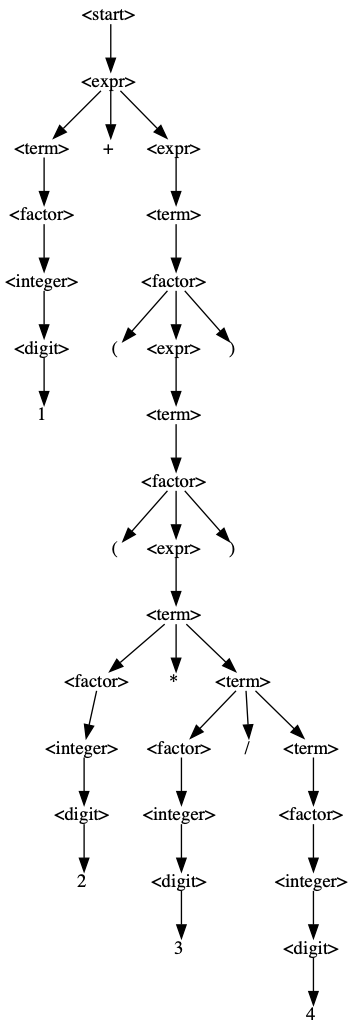

In [24]:
zoom(display_tree(parsed_expr))

#### A Fuzzer

In order to define abstraction, we need to be able to generate values based on a grammar. Our fuzzer is able to do that.

In [25]:
import random

##### The interface

In [26]:
class Fuzzer:
    def __init__(self, grammar):
        self.grammar = grammar

    def fuzz(self, key='<start>', max_num=None, max_depth=None):
        raise NotImplemented()

##### The implementation

The fuzzer tries to randomly choose an expansion when more than one expansion is available. If however, it goes beyond max_depth, then it chooses the cheapest nodes. The cheapest nodes are those nodes with minimum further expansion (no recursion).

In [27]:
class LimitFuzzer(Fuzzer):
    def symbol_cost(self, grammar, symbol, seen):
        if symbol in self.key_cost: return self.key_cost[symbol]
        if symbol in seen:
            self.key_cost[symbol] = float('inf')
            return float('inf')
        v = min((self.expansion_cost(grammar, rule, seen | {symbol})
                    for rule in grammar.get(symbol, [])), default=0)
        self.key_cost[symbol] = v
        return v

    def expansion_cost(self, grammar, tokens, seen):
        return max((self.symbol_cost(grammar, token, seen)
                    for token in tokens if token in grammar), default=0) + 1

    def gen_key(self, key, depth, max_depth):
        if key not in self.grammar: return key
        if depth > max_depth:
            assert key in self.cost
            clst = sorted([(self.cost[key][str(rule)], rule) for rule in self.grammar[key]])
            rules = [r for c,r in clst if c == clst[0][0]]
        else:
            rules = self.grammar[key]
        return self.gen_rule(random.choice(rules), depth+1, max_depth)

    def gen_rule(self, rule, depth, max_depth):
        return ''.join(self.gen_key(token, depth, max_depth) for token in rule)

    def fuzz(self, key='<start>', max_depth=10):
        return self.gen_key(key=key, depth=0, max_depth=max_depth)

    def __init__(self, grammar):
        super().__init__(grammar)
        self.key_cost = {}
        self.cost = self.compute_cost(grammar)

    def compute_cost(self, grammar):
        cost = {}
        for k in grammar:
            cost[k] = {}
            for rule in grammar[k]:
                cost[k][str(rule)] = self.expansion_cost(grammar, rule, set())
        return cost

In [28]:
expr_fuzzer = LimitFuzzer(EXPR_GRAMMAR)
expr_fuzzer.fuzz()

'+(-461.4 / +++3 * (6.4) / (3.0) * 2.3 * 4.8) / -230860.1767 / (+61 / (1 - 4.4) / 9.0 * 8 * 6.7 + -+2.4 / +3 * 7.2 / 8.1 + 4 * 4 * 2) / ((7 + 7.0) / 9 - 7.6 / 5.5 / 3.6 + 3.2 / 9.8 - 9 - 2) / +--5'

### Library functions

Finding nodes given the path

In [29]:
def find_node(node, path):
    name, children, *rest = node
    if not path:
        return node
    p, *path = path
    for i,c in enumerate(children):
        if i == p:
            return find_node(c, path)
    return None

In [30]:
find_node(parsed_expr, [0,1])

(' + ', [])

In [31]:
find_node(parsed_expr, [0,2,0,0,2])

(')', [])

In the grammar, we want to compute the minimum/maximum possible expansions for each nontermainal. The reason is that, if the number of expansions is limited (1) then, marking the parent for generalization does not get us anything. For parents with those nonterminals (honorary terminals), we register their grand parent.

In [32]:
import math

In [33]:
def find_maximum_expansions_for_key(grammar, key, seen_so_far):
    child_expansions = 0
    
    for rule in grammar[key]:
        rule_expansions = 1
        for token in rule:
            if token in seen_so_far:
                return math.inf
            if not is_nt(token):
                # only a single expansion
                rule_expansions *= 1
            else:
                v = find_maximum_expansions_for_key(grammar, token, seen_so_far | {key})
                rule_expansions *= v
        child_expansions += rule_expansions
    return child_expansions

In [34]:
def find_maximum_expansions(grammar):
    return {k:find_maximum_expansions_for_key(grammar, k, set()) for k in grammar}

In [35]:
find_maximum_expansions(EXPR_GRAMMAR)

{'<start>': inf,
 '<expr>': inf,
 '<term>': inf,
 '<factor>': inf,
 '<integer>': inf,
 '<digit>': 10}

First, collect the paths to the (unique) parents of each terminal symbol, then extend it by paths to the unique parents of each nonterminal that does not have enough expansions. From this, generate abstract trees with the particular node marked abstract.

Next, identify recursive nonterminals in the grammar. Identify nodes that are parents of terminal symbols that are recursive. Finally, generate new trees with these recursive nodes replaced by any of their closest chidren of same kind.


In [36]:
def find_matching_node_subpaths(node, fn):
    name, children = node
    if fn(node): return [[]]
    paths = []
    for i,c in enumerate(children):
        ps_ = find_matching_node_subpaths(c, fn)
        if ps_:
            ps = [[i] + p_ for p_ in ps_]
            paths.extend(ps)
    return paths

In [37]:
def match_factor(n):
    return n[0] == '<factor>'

In [38]:
paths = find_matching_node_subpaths(parsed_expr, match_factor)
for p in paths:
    print(p)
    n = find_node(parsed_expr, p)
    print(n[0], tree_to_str(n))

[0, 0, 0]
<factor> 1
[0, 2, 0, 0]
<factor> ((2 * 3 / 4))


In [39]:
def replace_tree(node, path, newnode):
    if not path:
        return newnode
    name, children = node
    hd, *subpath = path
    assert hd < len(children)
    new_children = []
    for i,c in enumerate(children):
        if i == hd:
            c_ = replace_tree(c, subpath, newnode)
        else:
            c_ = c
        new_children.append(c_)
    return (name, new_children)

In [40]:
tree_to_str(find_node(parsed_expr, [0,2,0,0]))

'((2 * 3 / 4))'

In [41]:
tree_to_str(replace_tree(parsed_expr, [0, 2, 0, 0], ('1', [])))

'1 + 1'

Validating a parse tree

In [42]:
def validate_tree(tree, grammar):
    def keys(arr):
        return [a[0] for a in arr]
    name, children, *rest = tree
    if not is_nt(name): return True
    
    seen = False
    for rule in grammar[name]:
        if keys(children) == rule:
            seen = True
    assert seen, name + ' needs ' + repr(grammar[name])
    for c in children:
        validate_tree(c, grammar)

In [43]:
validate_tree(parsed_expr, EXPR_GRAMMAR)

In [44]:
try:
    validate_tree(replace_tree(parsed_expr, [0, 2, 0, 0], ('1', [])), EXPR_GRAMMAR)
except AssertionError as e:
    print(e)

<term> needs [['<factor>', ' * ', '<term>'], ['<factor>', ' / ', '<term>'], ['<factor>']]


In [45]:
rt = replace_tree(parsed_expr, [0, 2, 0, 0], ('<factor>', [('<integer>', [('<digit>',[('1', [])])])]))
try:
    validate_tree(rt, EXPR_GRAMMAR)
except AssertionError as e:
    print(e)

In [46]:
tree_to_str(rt)

'1 + 1'

In [47]:
def grammar_gc(grammar, start_symbol):
    def strip_key(grammar, key, order):
        rules = sorted(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    if len(order) != len(grammar.keys()):
        stripped = [k for k in grammar if k not in order]
        if stripped:
            print("Stripping: %s" % str(stripped))
        faulty = [k for k in order if k not in grammar]
        assert not faulty
    return {k: [list(r) for r in sorted(grammar[k])] for k in order}

## Contextualization

The output that we get from `ddset` has nodes marked. So, we define a way to mark nodes as abstract.

### Mark the abstract nodes

Given a path, we mark the node as abstract.

In [48]:
def mark_path_abstract(tree, path):
    name, children = find_node(tree, path)
    new_tree = replace_tree(tree, path, (name, children, {'abstract': True}))
    return new_tree

First, we locate a suitable node.

In [49]:
abs_path_1 = [0,2,0,0,1,0,0,1]
tree_to_str(find_node(parsed_expr, abs_path_1))

'2 * 3 / 4'

In [50]:
v = mark_path_abstract(parsed_expr, abs_path_1); v

('<start>',
 [('<expr>',
   [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])]),
    (' + ', []),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', []),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', []),
                ('<expr>',
                 [('<term>',
                   [('<factor>', [('<integer>', [('<digit>', [('2', [])])])]),
                    (' * ', []),
                    ('<term>',
                     [('<factor>',
                       [('<integer>', [('<digit>', [('3', [])])])]),
                      (' / ', []),
                      ('<term>',
                       [('<factor>',
                         [('<integer>', [('<digit>', [('4', [])])])])])])])],
                 {'abstract': True}),
                (')', [])])])]),
          (')', [])])])])])])

Given a tree with some nodes marked abstract, go through the tree, and mark everything else as concrete. Default is to mark a node as concrete.

In [51]:
def mark_concrete_r(tree):
    name, children, *abstract_a = tree
    abstract = {'abstract': False} if not abstract_a else abstract_a[0]
    return (name, [mark_concrete_r(c) for c in children], abstract)

In [52]:
t = mark_concrete_r(v); t

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('<integer>',
         [('<digit>', [('1', [], {'abstract': False})], {'abstract': False})],
         {'abstract': False})],
       {'abstract': False})],
     {'abstract': False}),
    (' + ', [], {'abstract': False}),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', [], {'abstract': False}),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', [], {'abstract': False}),
                ('<expr>',
                 [('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('2', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' * ', [], {'abstract': False}),
                    ('<term>',
                     [('<factor>',
                      

A way to display the abstracted tree

In [53]:
def till_abstract(node):
    name, children, *rest = node
    if rest[-1]['abstract']:
        return (name + '*', [])
    return (name, [till_abstract(c) for c in children], *rest)

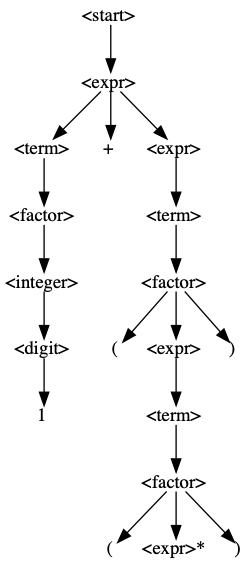

In [54]:
zoom(display_tree(till_abstract(t)))

In [55]:
abs_t1_ = find_node(parsed_expr, [0, 2])
tree_to_str(abs_t1_), abs_t1_[0]

('((2 * 3 / 4))', '<expr>')

In [56]:
abs_t1 = ('<start>', [abs_t1_])

In [57]:
validate_tree(abs_t1, EXPR_GRAMMAR)

In [58]:
t_abs_p1 = [0, 0, 0, 1, 0, 0, 1]
Ts(find_node(abs_t1, t_abs_p1))

'2 * 3 / 4'

We now define a function to check if a given node is abstract or not.

In [59]:
def e_g_(abstract_a):
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [60]:
def is_node_abstract(node):
    name, children, *abstract_a = node
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [61]:
def tree_to_str_a(tree):
    name, children, *general_ = tree
    if not is_nt(name): return name
    if is_node_abstract(tree):
        return name
    return ''.join([tree_to_str_a(c) for c in children])

In [62]:
Ta = tree_to_str_a

In [63]:
tree_to_str_a(t)

'1 + ((<expr>))'

In [64]:
abs_tree1 = mark_concrete_r(mark_path_abstract(abs_t1, t_abs_p1)); abs_tree1

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('(', [], {'abstract': False}),
              ('<expr>',
               [('<term>',
                 [('<factor>',
                   [('<integer>',
                     [('<digit>',
                       [('2', [], {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False})],
                   {'abstract': False}),
                  (' * ', [], {'abstract': False}),
                  ('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('3', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' / ', [], {'abstract': False}),
               

In [65]:
Ta(abs_tree1)

'((<expr>))'

In [66]:
def mark_abstract_nodes(tree, paths):
    for path in paths:
        tree = mark_path_abstract(tree, path)
    return mark_concrete_r(tree)

In [67]:
Ta(mark_abstract_nodes(abs_t1, []))

'((2 * 3 / 4))'

In [68]:
Ta(mark_abstract_nodes(abs_t1, [t_abs_p1]))

'((<expr>))'

### Finding characterizing node

A characterizing node is the lowest node that completely contains the given pattern.

In [69]:
 def find_charecterizing_node(tree):
    name, children, gen = tree
    if len(children) == 1:
        return find_charecterizing_node(children[0])
    return tree

In [70]:
abs_tree_cnode1 = find_charecterizing_node(abs_tree1); abs_tree_cnode1

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

As can be seen, the `<factor>` node completely contains the fault pattern.

In [71]:
abs_tree1[0], Ts(abs_tree1)

('<start>', '((2 * 3 / 4))')

In [72]:
abs_tree_cnode1[0], Ts(abs_tree_cnode1)

('<factor>', '((2 * 3 / 4))')

### Finding reachable keys

In [73]:
def find_reachable_keys(grammar, key, reachable_keys=None, found_so_far=None):
    if reachable_keys is None: reachable_keys = {}
    if found_so_far is None: found_so_far = set()

    for rule in grammar[key]:
        for token in rule:
            if not is_nt(token): continue
            if token in found_so_far: continue
            found_so_far.add(token)
            if token in reachable_keys:
                for k in reachable_keys[token]:
                    found_so_far.add(k)
            else:
                keys = find_reachable_keys(grammar, token, reachable_keys, found_so_far)
                # reachable_keys[token] = keys <- found_so_far contains results from earlier
    return found_so_far

In [74]:
for key in EXPR_GRAMMAR:
    keys = find_reachable_keys(EXPR_GRAMMAR, key, {})
    print(key, keys)

<start> {'<integer>', '<factor>', '<digit>', '<expr>', '<term>'}
<expr> {'<integer>', '<factor>', '<digit>', '<expr>', '<term>'}
<term> {'<integer>', '<factor>', '<digit>', '<expr>', '<term>'}
<factor> {'<integer>', '<factor>', '<digit>', '<expr>', '<term>'}
<integer> {'<digit>', '<integer>'}
<digit> set()


Finding recursive keys

In [75]:
def reachable_dict(grammar):
    reachable = {}
    for key in grammar:
        keys = find_reachable_keys(grammar, key, reachable)
        reachable[key] = keys
    return reachable

In [76]:
reachable_dict(EXPR_GRAMMAR)

{'<start>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<expr>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<term>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<factor>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<integer>': {'<digit>', '<integer>'},
 '<digit>': set()}

### Updating the grammar with failure keys

Now, we want to add our grammar the keys that are required to cause a failure. For that, we first extract the local grammar that reproduces the fault pattern 

#### Linear Grammar

In [77]:
abs_tree_cnode1

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

In [78]:
 def mark_faulty_name(symbol, prefix, v):
    return '<%s L%s_%s>'% (symbol[1:-1], prefix, v)

In [79]:
def mark_faulty_nodes(node, prefix, counter=None):
    if counter is None: counter = {}
    symbol, children, *abstract = node
    if is_node_abstract(node): # we dont markup further
        return node
    if symbol not in counter: counter[symbol] = 0
    counter[symbol] += 1
    v = str(counter[symbol])
    if is_nt(symbol):
        return (mark_faulty_name(symbol, prefix, v),
                [mark_faulty_nodes(c, prefix, counter) for c in children],
                *abstract)
    else:
        assert not children
        return (symbol, children, *abstract)

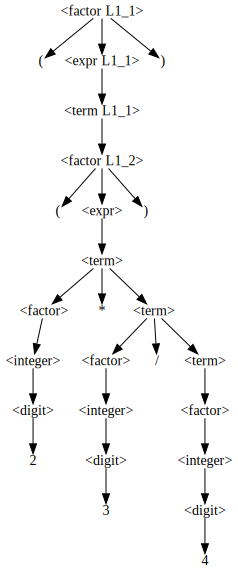

In [80]:
display_tree(mark_faulty_nodes(abs_tree_cnode1, '1'))

In [81]:
c_node1 = mark_faulty_nodes(abs_tree_cnode1, '1')

In [82]:
f_node1 = c_node1

In [83]:
def faulty_node_to_grammar(tree, grammar=None):
    if grammar is None: grammar = {}
    if is_node_abstract(tree): return grammar
    name, children, *rest = tree
    tokens = []
    if name not in grammar: grammar[name] = []
    for c in children:
        n, cs, *rest = c
        tokens.append(n)
        if is_nt(n):
            faulty_node_to_grammar(c, grammar)
    grammar[name].append(tuple(tokens))
    return grammar

In [84]:
faulty_node_to_grammar(abs_tree_cnode1)

{'<factor>': [('(', '<expr>', ')'), ('(', '<expr>', ')')],
 '<expr>': [('<term>',)],
 '<term>': [('<factor>',)]}

In [85]:
def faulty_node_to_linear_grammar(tree, prefix, grammar=None):
    ltree = mark_faulty_nodes(tree, prefix)
    return faulty_node_to_grammar(ltree)

In [86]:
faulty_node_to_linear_grammar(abs_tree_cnode1, '1')

{'<factor L1_1>': [('(', '<expr L1_1>', ')')],
 '<expr L1_1>': [('<term L1_1>',)],
 '<term L1_1>': [('<factor L1_2>',)],
 '<factor L1_2>': [('(', '<expr>', ')')]}

In [87]:
dd_tree_abs1 = abs_tree1

In [88]:
faulty_node1 = abs_tree_cnode1

### Finding insertable positions

Given a rule, and the faulty symbol, the positions in the rule where the fault can be inserted are all the non-terminals that will eventually reach the symbol of the faulty symbol. That is, if we have `<digit> + <expr>` as the expansion and the faulty symbol is `<factor*>` then, since `<digit>` can never reach `<factor>`, `0` is out, and so is `1` since it is a terminal symbol. Hence, only `<expr>` remains, which when expanded, one of the expansion paths will include a `<factor>`. Hence, here `[2]` is the answer.

In [89]:
def get_insertable_positions(rule, fkey, reachable):
    positions = []
    for i, token in enumerate(rule):
        if not is_nt(token): continue
        if fkey in reachable[token]:
            positions.append(i)
    return positions

In [90]:
reachable1 = reachable_dict(EXPR_GRAMMAR)

In [91]:
for k in EXPR_GRAMMAR:
    print(k)
    for rule in EXPR_GRAMMAR[k]:
        v = get_insertable_positions(rule, '<factor>', reachable1)
        print('\t', rule, v)

<start>
	 ['<expr>'] [0]
<expr>
	 ['<term>', ' + ', '<expr>'] [0, 2]
	 ['<term>', ' - ', '<expr>'] [0, 2]
	 ['<term>'] [0]
<term>
	 ['<factor>', ' * ', '<term>'] [0, 2]
	 ['<factor>', ' / ', '<term>'] [0, 2]
	 ['<factor>'] [0]
<factor>
	 ['+', '<factor>'] [1]
	 ['-', '<factor>'] [1]
	 ['(', '<expr>', ')'] [1]
	 ['<integer>', '.', '<integer>'] []
	 ['<integer>'] []
<integer>
	 ['<digit>', '<integer>'] []
	 ['<digit>'] []
<digit>
	 ['0'] []
	 ['1'] []
	 ['2'] []
	 ['3'] []
	 ['4'] []
	 ['5'] []
	 ['6'] []
	 ['7'] []
	 ['8'] []
	 ['9'] []


### Insert into key definition

 The essential idea is to make the rules in the grammar such that there is one fault position in each position.
Take one rule at a time. For each token in the rule, get the reachable tokens. If the fsym is not in reachable tokens, then the falt can nnot be inserted in that position. So get all positions for the rule that we can insert fsym in, and for each position, change the symbol for later insertion. `fsym_matches` are keys that already match the pattern we are trying to insert. So we need to leave them alone.

In [92]:
def to_faulty_key(name, prefix):
    return "<%s F%s>" % (name[1:-1], prefix)

In [93]:
def insert_into_key(grammar, key, fsym, fsym_matches, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_insertable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # skip this rule if no fsym_matches because we can not embed the fault here.
            for fsym_m in fsym_matches:
                m_positions = get_insertable_positions(rule, fsym_m, reachable)
                positions.extend(m_positions)
            # fsym_matches are those tokens that already embed the fault. Hence, no
            # fault insertion necessary
            if positions:
                my_rules.append(rule)           
        else:
            # at each position, insert the fsym
            for pos in positions:
                new_rule = list(copy.deepcopy(rule))
                new_rule[pos] = to_faulty_key(new_rule[pos], prefix)
                my_rules.append(new_rule)
    return (to_faulty_key(key, prefix), my_rules)

In [94]:
for key in EXPR_GRAMMAR:
    fk, rules = insert_into_key(EXPR_GRAMMAR, key, '<factor>', [], '1', reachable1)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start F1>
     ['<expr F1>']

<expr F1>
     ['<term F1>', ' + ', '<expr>']
     ['<term>', ' + ', '<expr F1>']
     ['<term F1>', ' - ', '<expr>']
     ['<term>', ' - ', '<expr F1>']
     ['<term F1>']

<term F1>
     ['<factor F1>', ' * ', '<term>']
     ['<factor>', ' * ', '<term F1>']
     ['<factor F1>', ' / ', '<term>']
     ['<factor>', ' / ', '<term F1>']
     ['<factor F1>']

<factor F1>
     ['+', '<factor F1>']
     ['-', '<factor F1>']
     ['(', '<expr F1>', ')']

<integer F1>

<digit F1>



In [95]:
def remove_duplicate_rules(grammar):
    return {k: list(set([tuple(rule) for rule in grammar[k]])) for k in grammar}

In [96]:
def insert_into_grammar(grammar, new_grammar, fsym, fsym_matches, prefix_f, reachable):
    for key in grammar:
        fk, rules = insert_into_key(grammar, key, fsym, fsym_matches, prefix_f, reachable)
        if not rules: continue # no applicable rules
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return remove_duplicate_rules(new_grammar)

### Get the final grammar

The final steps are as follows:
1. Add the fault node, and the child nodes to the grammar.
2. Generate the faulty key definitions. This is done per key in the original grammar.
3. Finally, connect the faulty key and fault node.

In [97]:
def get_faulty_grammar(grammar, start_symbol, fault_node, f_idx):
    def L_prefix(i): return '%d' % i
    def F_prefix(i): return '%d' % i
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # First, get the linear grammar

    g = faulty_node_to_linear_grammar(fault_node, prefix_l)
    new_grammar = {**g, **grammar}
    
    reachable = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    insert_into_grammar(grammar, new_grammar, key_f, [], prefix_f, reachable)

    # now, the faulty key is an alternative to the original
    fkey = mark_faulty_name(key_f, prefix_l, 1) # the starting in make_faulty is 1
    fsym = to_faulty_key(key_f, prefix_f)
    new_grammar[fsym].append([fkey])
        
    return to_faulty_key(start_symbol, F_prefix(f_idx)), new_grammar

In [98]:
start_faulty1, faulty_grammar1 = get_faulty_grammar(EXPR_GRAMMAR, '<start>', faulty_node1, 1); faulty_grammar1

{'<factor L1_1>': [('(', '<expr L1_1>', ')')],
 '<expr L1_1>': [('<term L1_1>',)],
 '<term L1_1>': [('<factor L1_2>',)],
 '<factor L1_2>': [('(', '<expr>', ')')],
 '<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']],
 '<start F1>': [['<expr F1>']],
 '<expr F1>': [['<term F1>', ' + ', '<expr>'],
  ['<term>', ' + ', '<expr F1>'],
  ['<term F1>', ' - ', '<expr>'],
  ['<term>', ' - ', '<expr F1>'],
  ['<term F1>']],
 '<term F1>': [['<factor F1>', ' * ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' / ', '

In [99]:
start_faulty1

'<start F1>'

In [100]:
gf1 = LimitFuzzer(faulty_grammar1)
parser1 = Parser(faulty_grammar1, canonical=True, start_symbol=start_faulty1)

In [101]:
for i in range(10):
    s = gf1.fuzz(key=start_faulty1)
    for t in parser1.parse(s):
        print(tree_to_str(t))
    print()

122 / 7 / +6.48098 * -+683.4 / 409.4 / 7.8 / +1.3 / +8 * 3.5 / 0.8 + 7340 + -+((2.9))

+8 - ----34 / ((2 - 9)) / (5 / 8.4 - (6.4) * 1.0 - 0.3 - 5 - 8) * +9.0 / 4 / (6.2) / 1 * 2 * 9.6

-+-5.01 / 28.74 * 6 + (3.9349 * +(3 - 8.9) / (1) * 5.6 - 048.3 * (2.7 + ((9))) / 5.0 - 1 - (4.2) / 3.6 / 2 - 2.5) / (-+-6.3 * (6.4 - 1.8) * 8 * 3 + (4.4 + 8.8) * (7) / 2 * 3.9 - (5.9) / 2.2 - 1.1 - 2) - 5.8 + (-2.3 / 0 / 8.4 * 9 + 8 / 5.1 - 2.3 - 5.4) * 350.55 + +(1 / 8 - 7 - 4.4) * 2.55 * -9.1 * +5 + 8.000

((+6 * 1.8 * 9)) / 51 + (800 - -4 * --6 / -5 / 6 + +-1.8 / 7.5 * 4.4 * 9.2) * (+-(7.1) + 9) * --0.861 / --6 - +(+-3 * (4.9) / 2 * 7.2 + -9.2 / 3.0 * 0)

(+65.6981 / 976.1 / +3 / (8 + 6) / 4.5) / 7 + 20051 / -+1.83 - +++0.89 * --8.6 * +-((7)) / -(8.2) / +(7) * 1 - 13.3

(--+(6 - ((8)) * 6.8) / -(4 + 5) / 08 * -5.1 / 4 / 2 / 8.6) + 5.87 * ++3889 / -2.4 * 1.41 * 203.3 / +6.2 / (9.7) * 8 / 7

(((3.7)) * -54.7 / 63 / (3.4 + 0.2) - (+4 * 0.2 - 5)) * 08 * 5

2844 * 11 * ((9 * 2.7 - 7) / ++((6)) / 9 / 6.9 - 

A few parses

In [102]:
for tree in parser1.parse('((2))'):
    print(tree_to_str(tree))

((2))


In [103]:
for tree in parser1.parse('((1 + 1))'):
    print(tree_to_str(tree))

((1 + 1))


In [104]:
try:
    for tree in parser1.parse('1 + 2'):
        print(tree)
except SyntaxError as e:
    print(e)

at '1 + 2'


In [105]:
for tree in parser1.parse('1 + ((3))'):
    print(tree_to_str(tree))

1 + ((3))


## Adding Another Fault

In [106]:
f2_grammar = grammar_gc(faulty_grammar1, start_faulty1); f2_grammar

Stripping: ['<start>']


{'<start F1>': [['<expr F1>']],
 '<expr F1>': [['<term F1>'],
  ['<term F1>', ' + ', '<expr>'],
  ['<term F1>', ' - ', '<expr>'],
  ['<term>', ' + ', '<expr F1>'],
  ['<term>', ' - ', '<expr F1>']],
 '<term F1>': [['<factor F1>'],
  ['<factor F1>', ' * ', '<term>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor>', ' / ', '<term F1>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor F1>': [['(', '<expr F1>', ')'],
  ['+', '<factor F1>'],
  ['-', '<factor F1>'],
  ['<factor L1_1>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<factor L1_1>': [['(', '<expr L1_1>', ')']],
 '<expr L1_1>': [['<term L1_1>']],
 '<term L1_1>': [['<factor L1_2>']],
 '<factor L1_2>': [['(', '<expr>', ')']],
 '<integer>': [['<digit>'], ['<digit>', 

### Abstract nodes

In [107]:
abs_path_2 = [0, 2, 0, 0, 1, 0, 0, 1, 0, 2]
tree2 = find_node(parsed_expr, abs_path_2)

In [108]:
tree2

('<term>',
 [('<factor>', [('<integer>', [('<digit>', [('3', [])])])]),
  (' / ', []),
  ('<term>', [('<factor>', [('<integer>', [('<digit>', [('4', [])])])])])])

In [109]:
find_node(tree2, [2])

('<term>', [('<factor>', [('<integer>', [('<digit>', [('4', [])])])])])

In [110]:
abs_tree2 = mark_abstract_nodes(tree2, [[0], [2]])

In [111]:
tree_to_str_a(abs_tree2)

'<factor> / <term>'

In [112]:
abs_tree2

('<term>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('3', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (' / ', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('4', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

### Characterizing node

In [113]:
abs_tree_cnode2 = find_charecterizing_node(abs_tree2); abs_tree_cnode2

('<term>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('3', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (' / ', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('4', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

In [114]:
c_node2 = mark_faulty_nodes(abs_tree_cnode2, '2'); c_node2

('<term L2_1>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('3', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (' / ', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('4', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

### Reachable keys

Next, we need to identify insertable positions. The complexity here is that we have some special nodes -- `L` and `F` that require special handling. For these, only the first part of the nt should be inspected. Note that the `L` node is the linearized fault pattern, while `F` is the guaranteed fault nonterminal.

Simple reachability analysis works for all nodes;

 However, simple reachability is not enough. We also have to check whether `L` nodes match directly, and if so, add them to reachable.

First, we find all the `L` keys, then, choose only those keys that correspond to the characteristic node of our fault. Only these can be inspected for direct match.

In [115]:
def is_linear(key): return ' L' in key

In [116]:
def normalize(key):
    assert key[0], key[-1] == ('<', '>')
    return '<%s>' % key[1:-1].split()[0]

In [117]:
nt_name2 = abs_tree_cnode2[0]; nt_name2

'<term>'

In [118]:
L0 = [key for key in f2_grammar if is_linear(key) and normalize(key) == '<factor>']; L0

['<factor L1_1>', '<factor L1_2>']

In [119]:
L1 = [key for key in f2_grammar if is_linear(key) and normalize(key) == nt_name2]; L1

['<term L1_1>']

How many of the above list will match our new fault pattern directly? Note that we are not interested in indirect matches as they will be included in the reachable dict anyway.

In [120]:
def to_rule(children):
    return [normalize(c[0]) if is_nt(c[0]) else c[0] for c in children]

In [121]:
[c[0] for c in c_node1[1]]

['(', '<expr L1_1>', ')']

In [122]:
to_rule(c_node1[1])

['(', '<expr>', ')']

In [123]:
c_node1

('<factor L1_1>',
 [('(', [], {'abstract': False}),
  ('<expr L1_1>',
   [('<term L1_1>',
     [('<factor L1_2>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
            

In [124]:
c_node2

('<term L2_1>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('3', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (' / ', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('4', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

TODO: There are two things to be careful about here: The new cnode could be more refined than the original: i.e new cnode is `(((<expr>)))` and the grammar represents `((<expr>))` or the new cnode could be more abstract: `(<expr>)`. Note that while grammar can present `((<expr ...>))`, cnode can never present `(<expr ...>)`. Unfortunately, these could be different on each abstract node, which could be many in the same cnode. These are not problematic in `f1 and f2` operations as we do not guarantee exact count, but should be handled in `f1 and not(f2)`.

In [125]:
def does_Lkey_produce_abs_pattern(grammar, key, cnode):
    name_c, children_c, *rest = cnode
    #assert ' ' not in name_c # not on marked cnodes
    rule_c = to_rule(children_c)
    nkey = normalize(key)
    if normalize(name_c) != nkey:
        return False
    if is_node_abstract(cnode): # we do not need to check anymore.
        # TODO: is the grammar more refined?
        return True
    
    # a not abstract key should be linear.
    if not is_linear(key):
        # TODO: is the cnode more refined?
        return False
    # print(key, 'matches', name_c)

    rules = grammar[key]
    for rule in rules:
        match = False
        n_rule = [normalize(t) if is_nt(t) else t for t in rule]
        if n_rule != rule_c: continue
        for k,c in zip(rule, children_c):
            if is_nt(k):
                match = does_Lkey_produce_abs_pattern(grammar, k, c)
            else:
                match = (k == c[0]) # terminals; does not need to normalize
            if not match:
                # to the next rule
                break
        #print("    ",rule_c)
        if match: return True
    return False

Verify that the `L` key of the same characteriztic node matches.

In [126]:
assert does_Lkey_produce_abs_pattern(f2_grammar, '<factor L1_1>', c_node1)

Note: `<factor L1_2>` corresponds to a single parenthesis. It should not match abs_tree_cnode1

In [127]:
assert not does_Lkey_produce_abs_pattern(f2_grammar, '<factor L1_2>', c_node1)

These should not match.

In [128]:
assert not does_Lkey_produce_abs_pattern(f2_grammar, '<term L1_1>', c_node1)

In [129]:
assert not does_Lkey_produce_abs_pattern(f2_grammar, '<term L1_1>', c_node2)

The following should match as it is again a single parenthesis

In [130]:
v = find_node(abs_tree_cnode1, [1,0]); tree_to_str_a(v)

'(<expr>)'

In [131]:
assert does_Lkey_produce_abs_pattern(f2_grammar, '<term L1_1>', v)

Now, we can extend our reachability; that is if `<term L1_1>` does match the given characteristic node, then reaching or being `<term L1_1>` is also sufficient for reachability.

In [132]:
def similar_nodes_to_cnode(f_grammar, cnode):
    c_node_key = normalize(cnode[0])
    # get all the matching Linear nodes to the characteristic node's starting key
    Lx = [key for key in f_grammar if is_linear(key) and normalize(key) == c_node_key]
    extra_reach = [kx for kx in Lx if does_Lkey_produce_abs_pattern(f_grammar, kx, cnode)]
    return extra_reach

Only `<factro L1_1>` (double paren) should match `cnode1`. In particular, `<factor L1_2>` (single paren) should not match the `cnode1`.

In [133]:
cx_node1 = mark_faulty_nodes(abs_tree_cnode1, '2x'); print(cx_node1[0])
er1 = similar_nodes_to_cnode(f2_grammar, cx_node1); er1

<factor L2x_1>


['<factor L1_1>']

In [134]:
similar_nodes_to_cnode(f2_grammar, c_node2)

[]

In [135]:
reachable2 = reachable_dict(f2_grammar)

In [136]:
for k in reachable2:
    print(k)
    for v in reachable2[k]:
        print("  ", v)
    print()

<start F1>
   <integer>
   <factor>
   <expr F1>
   <digit>
   <factor F1>
   <term F1>
   <term L1_1>
   <expr>
   <term>
   <factor L1_2>
   <expr L1_1>
   <factor L1_1>

<expr F1>
   <integer>
   <factor>
   <expr F1>
   <digit>
   <factor F1>
   <term F1>
   <term L1_1>
   <expr>
   <term>
   <factor L1_2>
   <expr L1_1>
   <factor L1_1>

<term F1>
   <integer>
   <factor>
   <expr F1>
   <digit>
   <factor F1>
   <term F1>
   <expr>
   <term>
   <factor L1_2>
   <factor L1_1>
   <term L1_1>
   <expr L1_1>

<expr>
   <integer>
   <factor>
   <digit>
   <expr>
   <term>

<term>
   <integer>
   <factor>
   <digit>
   <expr>
   <term>

<factor F1>
   <integer>
   <factor>
   <expr F1>
   <digit>
   <factor F1>
   <term F1>
   <expr>
   <term>
   <factor L1_2>
   <factor L1_1>
   <term L1_1>
   <expr L1_1>

<factor>
   <integer>
   <factor>
   <digit>
   <expr>
   <term>

<factor L1_1>
   <integer>
   <factor>
   <digit>
   <expr>
   <term>
   <factor L1_2>
   <term L1_1>
   <expr L1_1

If we are inserting `cx_node1`, then `<factor L1_1>` should be considered similar to `<factor>`, but no other factor.

In [137]:
faulty_node_to_linear_grammar(abs_tree_cnode2, '2')

{'<term L2_1>': [('<factor>', ' / ', '<term>')]}

In [138]:
for key in f2_grammar:
    fk, rules = insert_into_key(f2_grammar, key, '<factor>', [], '2', reachable2)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start F1 F2>
     ['<expr F1 F2>']

<expr F1 F2>
     ['<term F1 F2>']
     ['<term F1 F2>', ' + ', '<expr>']
     ['<term F1>', ' + ', '<expr F2>']
     ['<term F1 F2>', ' - ', '<expr>']
     ['<term F1>', ' - ', '<expr F2>']
     ['<term F2>', ' + ', '<expr F1>']
     ['<term>', ' + ', '<expr F1 F2>']
     ['<term F2>', ' - ', '<expr F1>']
     ['<term>', ' - ', '<expr F1 F2>']

<term F1 F2>
     ['<factor F1 F2>']
     ['<factor F1 F2>', ' * ', '<term>']
     ['<factor F1>', ' * ', '<term F2>']
     ['<factor F1 F2>', ' / ', '<term>']
     ['<factor F1>', ' / ', '<term F2>']
     ['<factor F2>', ' * ', '<term F1>']
     ['<factor>', ' * ', '<term F1 F2>']
     ['<factor F2>', ' / ', '<term F1>']
     ['<factor>', ' / ', '<term F1 F2>']

<expr F2>
     ['<term F2>']
     ['<term F2>', ' + ', '<expr>']
     ['<term>', ' + ', '<expr F2>']
     ['<term F2>', ' - ', '<expr>']
     ['<term>', ' - ', '<expr F2>']

<term F2>
     ['<factor F2>']
     ['<factor F2>', ' * ', '<term>']
     [

In [139]:
faulty_node2 = abs_tree_cnode2

In [140]:
def get_faulty_grammar(grammar, start_symbol, fault_node, f_idx):
    def L_prefix(i): return '%d' % i
    def F_prefix(i): return '%d' % i
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # First, get the linear grammar

    g = faulty_node_to_linear_grammar(fault_node, prefix_l)
    new_grammar = {**g, **grammar}
    
    reachable = reachable_dict(grammar)
    similar_nodes = similar_nodes_to_cnode(grammar, fault_node)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    insert_into_grammar(grammar, new_grammar, key_f, similar_nodes, prefix_f, reachable)

    # now, the faulty key is an alternative to the original
    fkey = mark_faulty_name(key_f, prefix_l, 1) # the starting in make_faulty is 1
    fsym = to_faulty_key(key_f, prefix_f)
    new_grammar[fsym].append([fkey])
        
    return to_faulty_key(start_symbol, F_prefix(f_idx)), new_grammar

In [141]:
start_faulty2, faulty_grammar2_ = get_faulty_grammar(faulty_grammar1, start_faulty1, faulty_node2, 2);
faulty_grammar2 = grammar_gc(faulty_grammar2_, start_faulty2); faulty_grammar2

Stripping: ['<start>', '<start F1>', '<start F2>']


{'<start F1 F2>': [['<expr F1 F2>']],
 '<expr F1 F2>': [['<term F1 F2>'],
  ['<term F1 F2>', ' + ', '<expr>'],
  ['<term F1 F2>', ' - ', '<expr>'],
  ['<term F1>', ' + ', '<expr F2>'],
  ['<term F1>', ' - ', '<expr F2>'],
  ['<term F2>', ' + ', '<expr F1>'],
  ['<term F2>', ' - ', '<expr F1>'],
  ['<term>', ' + ', '<expr F1 F2>'],
  ['<term>', ' - ', '<expr F1 F2>']],
 '<term F1 F2>': [['<factor F1 F2>'],
  ['<factor F1 F2>', ' * ', '<term>'],
  ['<factor F1 F2>', ' / ', '<term>'],
  ['<factor F1>', ' * ', '<term F2>'],
  ['<factor F1>', ' / ', '<term F2>'],
  ['<factor F2>', ' * ', '<term F1>'],
  ['<factor F2>', ' / ', '<term F1>'],
  ['<factor>', ' * ', '<term F1 F2>'],
  ['<factor>', ' / ', '<term F1 F2>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term F1>': [['<factor F1>'],
  ['<factor F1>', ' * ', '<term>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor>', ' / ', '<term F1>']],
 '<expr F2>': 

In [142]:
gf2 = LimitFuzzer(faulty_grammar2)
parser2 = Parser(faulty_grammar2, canonical=True, start_symbol=start_faulty2)

In [143]:
for i in range(10):
    s = gf2.fuzz(key=start_faulty2)
    for t in parser2.parse(s):
        print(tree_to_str(t))
    print()

++-(-1.2 * -6 / 2.3 * 6.0 + 3.0 - 7 * 4.8) / +--((9)) / (6 - -5 - 7 / 1.4 / 8.8) / +-(8.5 / 4.0) * -7 + 3 * 3 + +-67 / -6.1260
++-(-1.2 * -6 / 2.3 * 6.0 + 3.0 - 7 * 4.8) / +--((9)) / (6 - -5 - 7 / 1.4 / 8.8) / +-(8.5 / 4.0) * -7 + 3 * 3 + +-67 / -6.1260
++-(-1.2 * -6 / 2.3 * 6.0 + 3.0 - 7 * 4.8) / +--((9)) / (6 - -5 - 7 / 1.4 / 8.8) / +-(8.5 / 4.0) * -7 + 3 * 3 + +-67 / -6.1260

4 / 1.5 * 0 * -((8.8)) * 53.0 * --+9 / (4.6 + 7.2) + (354.1 + +0 / (7.7) / 0 - +(6) * -9.2 * 6.2 - 3 * 8 * 2 + 8.1 * 3.1) * (-1 / 57.2 * (0.3))
4 / 1.5 * 0 * -((8.8)) * 53.0 * --+9 / (4.6 + 7.2) + (354.1 + +0 / (7.7) / 0 - +(6) * -9.2 * 6.2 - 3 * 8 * 2 + 8.1 * 3.1) * (-1 / 57.2 * (0.3))

09177481.0 * -+-+++-(0.1 / 7.2) + -0.2 * 99.13 * +-0.540 - 463.4 * 3.8 / 7.553 * (7.7 * 2.2 - 0 + 9.7) - -((9.3)) * 2 / 40 - 1 / 7.1
09177481.0 * -+-+++-(0.1 / 7.2) + -0.2 * 99.13 * +-0.540 - 463.4 * 3.8 / 7.553 * (7.7 * 2.2 - 0 + 9.7) - -((9.3)) * 2 / 40 - 1 / 7.1

((63 / +3 / 3.9 - (0.3) / 3 / 0.5 + 8 / 6 + 5 + 1.4 / 5.7) / +